In [72]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import cv2
import numpy as np
from ImageGenerator import ImageAugmentation
from tensorflow.keras.utils import plot_model

In [73]:
def load_image(image_path, expression_index, gender_label):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    label = [expression_index, 0 if gender_label == 'male' else 1]
    return img, label

def load_expression_data(directory, expression_index, expression_label):
    images = []
    labels = []
    for gender_label in os.listdir(os.path.join(directory, expression_label)):
        image_dir = os.path.join(directory, expression_label, gender_label)
        image_paths = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
        for image_path in image_paths:
            image, label = load_image(image_path, expression_index, gender_label)
            images.append(image)
            labels.append(label)
    return images, labels

def load_data(directory, max_workers=7):
    expressions = os.listdir(directory)
    all_images = []
    all_labels = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = executor.map(load_expression_data, [directory]*len(expressions), range(len(expressions)), expressions)
        for images, labels in results:
            all_images.extend(images)
            all_labels.extend(labels)
    all_labels = np.array(all_labels)
    all_labels = all_labels.reshape(-1, 2)
    return np.vstack(all_images), all_labels

In [74]:
images, labels = load_data('data/face_expression_gender')
images.shape, labels.shape

((33619, 48, 48, 1), (33619, 2))

In [76]:
dict_gender = {
    0: 'male',
    1: 'female',
}

dict_expression = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise',
}

In [106]:
def plot_label_distribution(labels):
    unique_labels = np.unique(labels, axis=0)
    counts = np.zeros(len(unique_labels))
    for i, label in enumerate(unique_labels):
        counts[i] = np.sum(np.all(labels == label, axis=1))
    plt.bar(range(len(unique_labels)), counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution')
    plt.xticks(range(len(unique_labels)), [f'{dict_expression[label[0]]} {dict_gender[label[1]]}' for label in unique_labels], rotation=30, fontsize=8)
    for i, v in enumerate(counts):
        plt.text(i, v + 0.5, str(int(v)), ha='center', fontsize=8)
    plt.show()

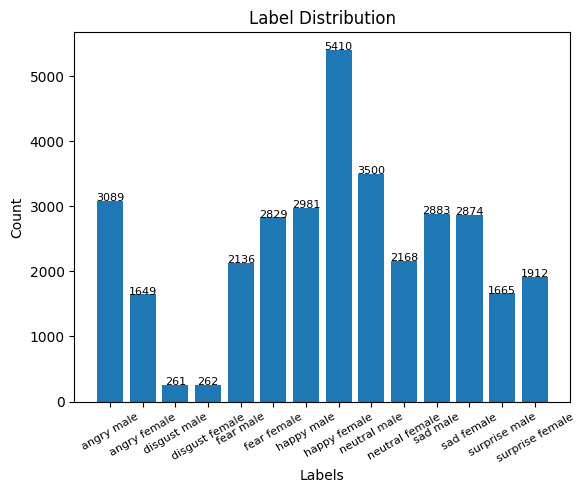

In [107]:
plot_label_distribution(labels)

In [108]:
def show_sample_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        index = np.random.randint(0, len(images))
        axes[i].imshow(images[index], cmap='gray')
        axes[i].set_title(f'{dict_expression[labels[index][0]]} - {dict_gender[labels[index][1]]}')
        axes[i].axis('off')
    plt.show()

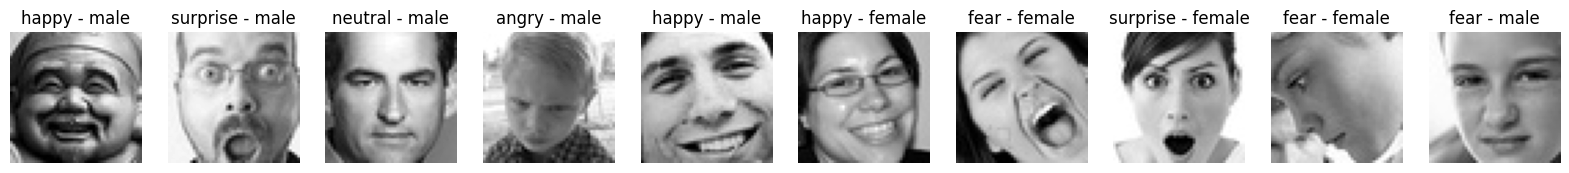

In [109]:
show_sample_images(images, labels)

In [110]:
def downsample(images, labels, n_samples):
    labels_as_tuples = [tuple(label) for label in labels]
    unique_labels = set(labels_as_tuples)
    downsampled_images = []
    downsampled_labels = []
    for label in unique_labels:
        indices = [i for i, lbl in enumerate(labels_as_tuples) if lbl == label]
        if len(indices) < n_samples:
            print(f"Warning: Class {label} only has {len(indices)} samples, less than {n_samples}")
            selected_indices = indices
        else:
            selected_indices = np.random.choice(indices, n_samples, replace=False)
        downsampled_images.extend(images[i] for i in selected_indices)
        downsampled_labels.extend(labels[i] for i in selected_indices)
    
    return np.array(downsampled_images), np.array(downsampled_labels)

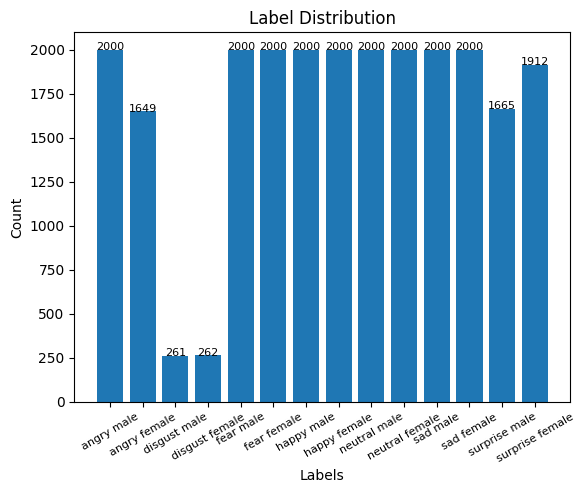

In [111]:
downsampled_images, downsampled_labels = downsample(images, labels, n_samples=2000)
plot_label_distribution(downsampled_labels)

In [112]:
augmentator = ImageAugmentation(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

In [113]:
def image_augmentation(images, labels, target_label, num_augmentations=5):
    augmented_images = []
    augmented_labels = []
    augmented_images.extend(images)
    augmented_labels.extend(labels)
    target_indices = [i for i, label in enumerate(map(tuple, labels)) if label == target_label]
    target_images = [images[i] for i in target_indices]
    target_labels = [labels[i] for i in target_indices]
    images_temp, labels_temp = augmentator.flow(images=target_images, labels=target_labels, num_augmentations=num_augmentations, shuffle=True)
    show_sample_images(images_temp, labels_temp, num_images=10)
    augmented_images.extend(images_temp)
    augmented_labels.extend(labels_temp)
    return np.array(augmented_images), np.array(augmented_labels)


Generated 1566 augmented images.


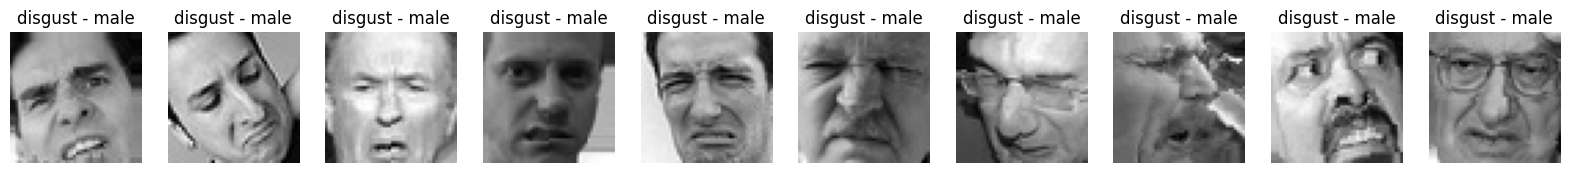

Generated 1572 augmented images.


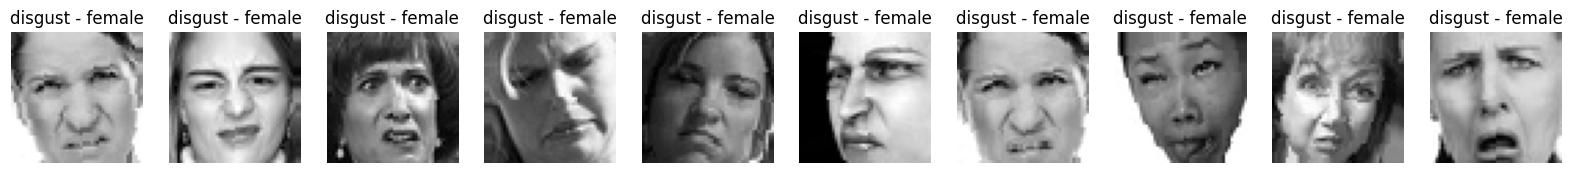

In [114]:
augmented_images, augmented_labels = image_augmentation(images, labels, (1, 0), num_augmentations=5)
augmented_images, augmented_labels = image_augmentation(augmented_images, augmented_labels, (1, 1), num_augmentations=5)

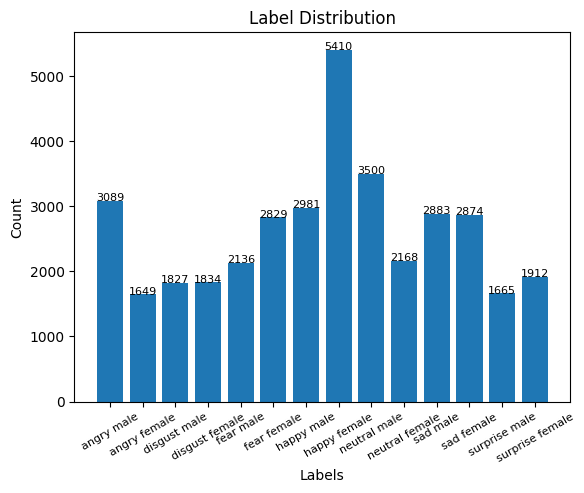

In [115]:
plot_label_distribution(augmented_labels)

In [116]:
x_train, x_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape
y_train_1, y_train_2 = y_train[:, 0], y_train[:, 1]
y_test_1, y_test_2 = y_test[:, 0], y_test[:, 1]

In [162]:
inputs = tf.keras.layers.Input(shape=(48, 48, 1))
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)

dense_1 = tf.keras.layers.Dense(512, activation='relu')(x)
dense_1 = tf.keras.layers.Dropout(0.5)(dense_1)
dense_1 = tf.keras.layers.Dense(256, activation='relu')(dense_1)
dense_1 = tf.keras.layers.Dropout(0.5)(dense_1)
output_1 = tf.keras.layers.Dense(7, activation='softmax', name='expression')(dense_1)

dense_2 = tf.keras.layers.Dense(256, activation='relu')(x)
dense_2 = tf.keras.layers.Dropout(0.5)(dense_2)
dense_2 = tf.keras.layers.Dense(128, activation='relu')(dense_2)
dense_2 = tf.keras.layers.Dropout(0.5)(dense_2)
output_2 = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(dense_2)

model = tf.keras.models.Model(inputs=inputs, outputs=[output_1, output_2])
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'binary_crossentropy'], metrics=['accuracy'])
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_53 (Conv2D)             (None, 46, 46, 64)   640         ['input_20[0][0]']               
                                                                                                  
 max_pooling2d_53 (MaxPooling2D  (None, 23, 23, 64)  0           ['conv2d_53[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 21, 21, 128)  73856       ['max_pooling2d_53[0][0]']

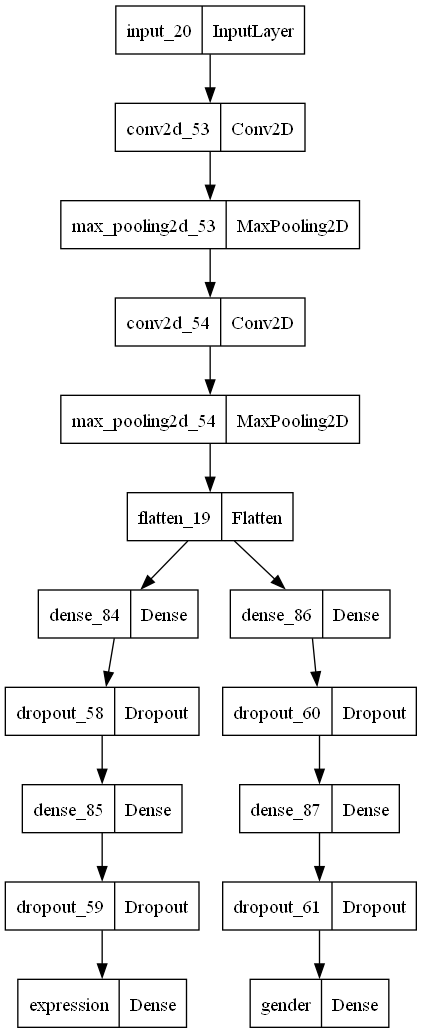

In [163]:
plot_model(model)

In [164]:
history = model.fit(x_train, [y_train_1, y_train_2], epochs=10, batch_size=32, validation_data=(x_test, [y_test_1, y_test_2]))

Epoch 1/10
919/919 [==============================] - 17s 16ms/step - loss: 2.3167 - expression_loss: 1.7235 - gender_loss: 0.5933 - expression_accuracy: 0.3274 - gender_accuracy: 0.6762 - val_loss: 2.0137 - val_expression_loss: 1.4866 - val_gender_loss: 0.5271 - val_expression_accuracy: 0.4370 - val_gender_accuracy: 0.7300
Epoch 2/10
919/919 [==============================] - 15s 17ms/step - loss: 1.9668 - expression_loss: 1.4631 - gender_loss: 0.5037 - expression_accuracy: 0.4447 - gender_accuracy: 0.7505 - val_loss: 1.8535 - val_expression_loss: 1.3734 - val_gender_loss: 0.4801 - val_expression_accuracy: 0.4786 - val_gender_accuracy: 0.7629
Epoch 3/10
919/919 [==============================] - 12s 14ms/step - loss: 1.8085 - expression_loss: 1.3456 - gender_loss: 0.4628 - expression_accuracy: 0.4946 - gender_accuracy: 0.7756 - val_loss: 1.7864 - val_expression_loss: 1.3003 - val_gender_loss: 0.4861 - val_expression_accuracy: 0.5015 - val_gender_accuracy: 0.7594
Epoch 4/10
919/919 [==

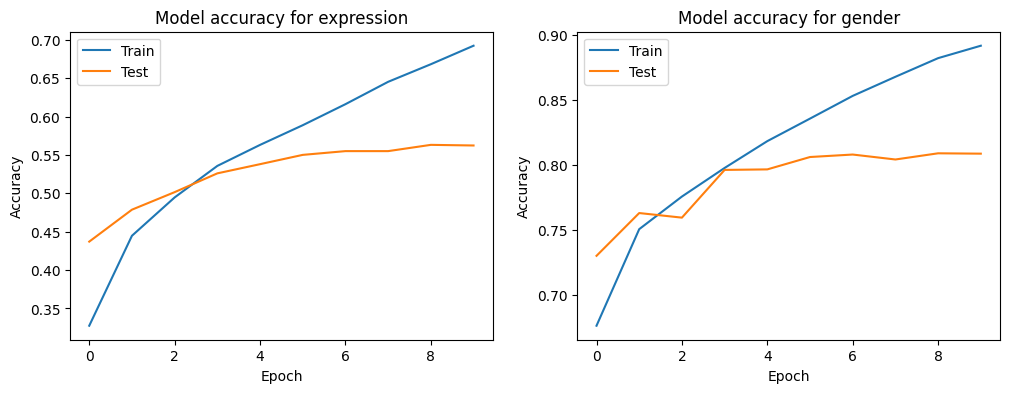

In [165]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['expression_accuracy'])
plt.plot(history.history['val_expression_accuracy'])
plt.title('Model accuracy for expression')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title('Model accuracy for gender')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [166]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
y_pred_1 = np.argmax(y_pred[0], axis=1)
y_pred_2 = np.round(y_pred[1]).flatten()
    

230/230 [==============================] - 1s 4ms/step


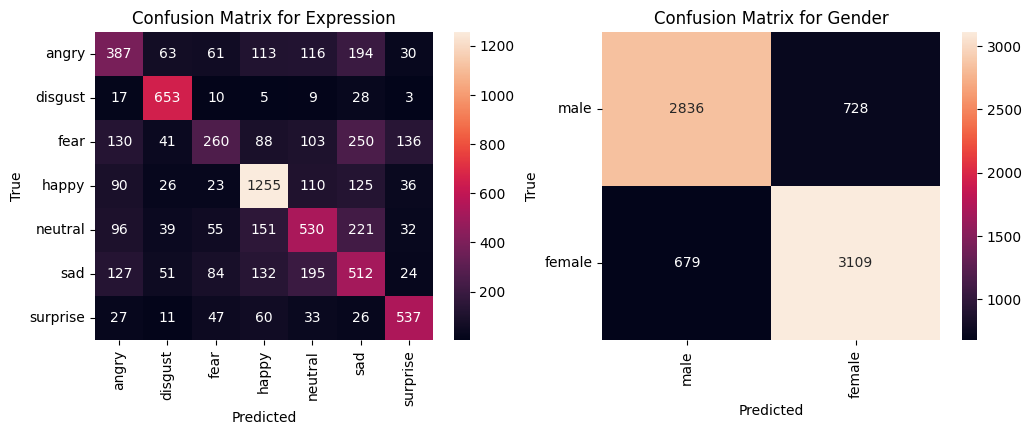

In [167]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test_1, y_pred_1), annot=True, fmt='d')
plt.title('Confusion Matrix for Expression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(len(dict_expression))+0.5, dict_expression.values(), rotation=90)
plt.yticks(np.arange(len(dict_expression))+0.5, dict_expression.values(), rotation=0)

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test_2, y_pred_2), annot=True, fmt='d')
plt.title('Confusion Matrix for Gender')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(len(dict_gender))+0.5, dict_gender.values(), rotation=90)
plt.yticks(np.arange(len(dict_gender))+0.5, dict_gender.values(), rotation=0)

plt.show()